# Overview

*Adaptie SIS Model Simulation (faster)*

The notebook implements an adaptive SIS (Susceptible-Infected-Susceptible) model on a complex network. The network structure evolves over time, where susceptible nodes only reconnect to susceptible nodes they previously met. The code simulates disease transmission, recovery, and network evolution.

**Key Features:**
- Dynamic reconnections based on disease status.
- Monte Carlo simulation for epidemic modeling.
- Visualizations of epidemic statistics (characteristic lifetime, metastable prevalence of infected).





# How to use (Recommended version)

Set the parameters you want in "Parameter section". Also set the parameters at the beggining of the MAIN you want to use. The main will run the simulation. The main figures are in the following cells.

If you want to save the figures, replace a valid directory in the line directorio = '/set one valid directory/' in the section Drive Folder Connection. Then set save=True in their arguments.

ATTENTION. This code could have issues in some computers. Avoid doing anything else while the program is running. If you are using the computers on the physics room, it has be tested in number 2. Number 6 has issues with memory usage.

# Libraries

In [ ]:
# Use this in the terminal if you don't have anyone
#pip install networkx[default]
#pip install joblib
#pip install gc

In [ ]:
import networkx as nx
import numpy as np
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from joblib import Parallel, delayed

## Directory

Set the directory to save figures.

In [ ]:
#If you run in colab (remember Free Colab just have 2 threads available)
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [ ]:
# Replace with one valid directory/

directorio = '/set one valid directory/'

In [ ]:
import datetime
NOW = datetime.datetime.now()
MINUTE = NOW.minute
HOUR = NOW.hour
DAY = NOW.day

# Graph Initialization

initialize_graph( N,k,p_ws,infect_percent,seed_G)

In [ ]:
'''
  Al llamarse se inicializa el grafo de Watts Strogatz, así como otros
elementos importantes para el programa
  G_base := grafo inicial, no cambia durante el programa
  G := el grafo principal
  status := Estados de los nodos
  new_status := auxiliar de status
  pos = guarda las posiciones de los nodos en el plotting

'''
def initialize_graph( N,k,p_ws,infect_percent,seed_G):
  global pos
  # Inicializar un grafo y una copia con networkx
  G = nx.watts_strogatz_graph(N, k, p_ws, seed=seed_G)
  G_base = G.copy()
  # Estado inicial de los nodos: 0 = susceptible, 1 = infectado
  status = np.zeros(N)
  initial_infected = np.random.choice(N, size=int(N*infect_percent),
                                      replace=False)
  #print(np.sort(initial_infected))
  status[initial_infected] = 1

  # Initialize positions
  pos = nx.spring_layout(G, seed=1)
  return G, G_base, status

# Draw

Draw the graphs and makes a video for one run of the evolution of the system.

draw( G, status, step)

In [ ]:
'''
   Dibuja el grafo en un tiempo t
'''
def draw( G, status, step):
  # Colorear los nodos según su estado inicial
  node_colors = ['red' if status[node] == 1 else 'green' for node in G.nodes]
  # Dibujar el grafo con los nodos coloreados
  nx.draw(G, pos=pos, node_color=node_colors, with_labels=True)
  # Add title to the figure
  plt.title(f"Graph Evolution: step = {step+1}")
  plt.show()

# Evolution step

evolution_step(G, G_base, status,random_array):

In [ ]:
'''
  Un paso en el tiempo de la simulación
'''
def evolution_step(G, G_base, status,random_array,rand_idx):
    new_status = status.copy()
    nodes = list(G.nodes)
    for i in nodes:
        ## Recovery with numpy where (soon)

        if status[i] == 1:  # Infected
            # Recovery
            if random_array[rand_idx] < p_recov:
                new_status[i] = 0
            rand_idx+=1

            neighbors = list(G.neighbors(i))
            # Disease transmission
            for neighbor in neighbors:
                if status[neighbor] == 0:
                    if random_array[rand_idx] < p_inf:
                        new_status[neighbor] = 1
                    rand_idx+=1
                    if random_array[rand_idx] < p_break:
                        G.remove_edge(i, neighbor)
                    rand_idx+=1

        else:  # Susceptible
            # Link creation (S-S links only)
            potential_neighbors = set(G_base.neighbors(i)) - set(G.neighbors(i))
            for neighbor in potential_neighbors:
                if status[neighbor] == 0 and random_array[rand_idx] < p_create:
                    G.add_edge(i, neighbor)
                rand_idx+=1

    return G, new_status,rand_idx

# Infected vs time

save_infected(infected_in_time, status, step)

average_infected_in_steps(infected_in_time, av_steps)

plot_infected(infected_in_time, averaging_steps = 1, seeds = 1)

In [ ]:
## BORRAR abajo
'''
def initialize_plot():
  global infected_in_time, num_edges, steps
  infected_in_time = np.zeros(steps)
  num_edges = np.zeros(steps)
'''

def save_infected(infected_in_time, status, step):
  #global status, infected_in_time, num_edges
  infected_in_time[step] = np.sum(status)/N
  #num_edges[step] = G.number_of_edges()/(N*k/2) #(N*k/2) is the initial num of edges

def average_infected_in_steps(infected_in_time, av_steps):
    steps = len(infected_in_time)
    inf_aux = np.zeros(steps-av_steps+1)

    for step in range(steps-av_steps+1):
        inf_aux[step] = np.sum(infected_in_time[step:step+av_steps])
    inf_aux = inf_aux / av_steps

    return inf_aux

def plot_infected(infected_in_time, averaging_steps = 1, seeds = 1):
  if averaging_steps > 1:
    infected_in_time = average_infected_in_steps(infected_in_time, averaging_steps)

  size_x = len(infected_in_time)
  X = np.arange(size_x)

  # Create figure and axis objects
  fig1, ax1 = plt.subplots()

  # Plot the first line
  color='tab:red'
  ax1.set_xlabel('Step')
  ax1.set_ylabel('Fraction of infected', color=color)
  ax1.plot(X, infected_in_time, color=color, label='Infected [I]')
  ax1.tick_params(axis='y', labelcolor=color)
  #plt.title(f'N = {N}, k = {k}, tau = {p_inf/p_recov}, omega = {p_create/p_break},\n averaged over {seeds} seeds and {averaging_steps} steps')
  plt.title(f'N = {N}, k = {k}, tau = {(p_inf/p_recov):.2f}, omega = {(p_create/p_break):.2f}' +
          (f'\n averaged over {seeds} seeds' if seeds > 1 else '') +
          (f'\n averaged over {averaging_steps} steps' if averaging_steps > 1 else ''))

  plt.show()


# Parameters

Model and network parameters

In [ ]:
### PARÁMETROS DEL MODELO

p_inf = 0.2 #Probabilidad de infectarse (S->I)
p_recov = 0.2 #Probabilidad de recuperarse (I->S)
p_break = 0.2 #Propabilidad de desconexion
p_create = 0.2 #Probabilidad de creacion

### PARÁMETROS DE RED

N = 20     #N:Nodos
k = 8      #k:Grado promedio
p_ws = 0.2  #p: probabilidad de watts-strogats

infect_percent = 0.5 #Infectados iniciales

### PLOT IN TIME

### VIDEO
fps = 2  # Frames per second

# About Prevalence

Functions to calculate the prevalence of infected nodes and plot


```
find_prevalence(infected_just_endemic, n_endemic_states, seeds, min_fraction=0.7, plot=False, save=False)

prevalence_vs_tau(prevalence, tau, std = None, omega=p_break/p_create)
```

In [ ]:
#Prevalencia de infectados

def find_prevalence(infected_just_endemic, n_endemic_states, seeds, min_fraction=0.3, m_loc_min=3, omega=-1, tau = -1, plot=False, save=False):
  '''Returns the mean of infected and standar deviation of infected
  where there is still more than 0.7 states in infected season'''
  #step_of_healty = np.argmax(infected_in_time == 0)
  # First a pre- prevalence
  infected_to_analyse = infected_just_endemic[n_endemic_states>min_fraction]
  mean_infected = np.mean(infected_to_analyse)
  std_dev_infected = np.std(infected_to_analyse)

  # This section avoid to analyse the non-metaestable part at the beginning
  first_idx = np.where(infected_to_analyse<mean_infected)[0][0]
  preva_infected_to_analyse = infected_to_analyse[first_idx:]



  # This section try to solve some issues with small taus, finding a lm_idx local minima,
  # and ignoring infected before this one
  local_minima_indices = (np.diff(np.sign(np.diff(preva_infected_to_analyse))) > 0).nonzero()[0] + 1

  if len(local_minima_indices) > m_loc_min:
    lm_idx = local_minima_indices[m_loc_min]
  else:
    for i in range(10):
      min_fraction = 0.5*min_fraction
      infected_to_analyse = infected_just_endemic[n_endemic_states>min_fraction]
      preva_infected_to_analyse = infected_to_analyse[first_idx:]
      local_minima_indices = (np.diff(np.sign(np.diff(preva_infected_to_analyse))) > 0).nonzero()[0] + 1
      if len(local_minima_indices) > m_loc_min:
        lm_idx = local_minima_indices[m_loc_min]
        break
      else:
        lm_idx = len(preva_infected_to_analyse)-3
  mean_infected = np.mean(preva_infected_to_analyse[lm_idx:])
  std_dev_infected = np.std(preva_infected_to_analyse[first_idx:])


  # Figure
  if plot or save:
    size_x = len(infected_to_analyse)
    X = np.arange(size_x)
    plt.plot(X, infected_to_analyse, label=f'Infected Mean over {seeds} seeds', color='tab:blue', zorder=1)
    vec_prevalence = np.full( size_x, mean_infected)
    plt.plot(X, vec_prevalence, color='red', label='Prevalence', linestyle='--', zorder=3)
    vec_std = np.full(size_x, std_dev_infected)
    plt.fill_between(X, vec_prevalence - vec_std, vec_prevalence + vec_std, color='red', alpha=0.2, label='Standard Deviation', zorder=2)
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Fraction of infected')
    plt.title(f'Prevalence for ' + r'$\tau$ = '+ f'{tau:.2f} and '+ r'$\omega$ = '+f'{omega:.2f} \n N = {N}, k = {k}, seeds = {seeds}')
    plt.grid(True)
    if save: plt.savefig(directorio + f'Prevalence tau = {tau:.2f} omega = {omega:.2f} seeds = {seeds} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    if plot:
      plt.show()
  return mean_infected, std_dev_infected


def prevalence_vs_tau(prevalence, tau, std = None, omega=p_break/p_create, seeds = None, steps=None, save= False):
  plt.plot(tau, prevalence, marker='o', linestyle='-', label='Prevalence', color='tab:red')
  if isinstance(std, np.ndarray):
    plt.fill_between(tau, prevalence - std, prevalence + std, alpha=0.2,label='Standard Deviation', color='tab:red')
  plt.legend()
  plt.xlabel(r'Effective infection rate $\tau$')
  plt.ylabel('Prevalence of infected')
  plt.title(r'Prevalence vs $\tau$'+ '\n ' + f'N = {N}, k = {k},' +r' $\omega$ = '+f'{omega:.2f}' +(f',\n seeds = {seeds}' if seeds else '')+(f', steps = {steps}' if steps else ''))
  if save: plt.savefig(directorio + f'Prevalence vs Tau omega = {omega:.2f} N = {N} k = {k} seeds = {seeds} fecha-{DAY}-{HOUR}:{MINUTE}.png')
  plt.show()

#Plot prevalence vs Tau per omega
def plot_prevalence_vs_tau(taus, prevalence_per_omega, std_prevalence_per_omega, seeds=None, save=False):
   # Normal plot
    #plt.figure(figsize=(10, 6))
    for omega in prevalence_per_omega.keys():
        plt.errorbar(taus, prevalence_per_omega[omega], yerr=std_prevalence_per_omega[omega],
                     label=r' $\omega$ = ' + f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o',markerfacecolor='none')
    # Axis labels with LaTeX formatting
    plt.xlabel(r'Effective infection rate $\tau$', fontsize=10.5)
    plt.ylabel('Prevalence of Infected', fontsize=10.5)

    # Title with network parameters

    plt.title(r'$\bf{Prevalence\ of\ Infected\ vs.\ }\tau$' + '\n' +
          f'N = {N}, k = {k}' + (f', seeds = {seeds}' if seeds else '') +
        (f', steps = {steps}' if steps else ''), fontsize=13)
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Prevalence vs Tau per Omega k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()

    # Semilog plot
    #plt.figure(figsize=(10, 6))
    for omega in prevalence_per_omega.keys():
        plt.errorbar(taus, prevalence_per_omega[omega], yerr=std_prevalence_per_omega[omega],
                     label=r' $\omega$ = ' + f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o',markerfacecolor='none')
    # Axis labels with LaTeX formatting
    plt.xlabel(r'Effective infection rate $\tau$', fontsize=10.5)
    plt.ylabel('Prevalence of Infected', fontsize=10.5)

    # Title with network parameters
    plt.title(r'$\bf{Prevalence\ of\ Infected\ vs.\ }\tau$' + '\n' +
          f'N = {N}, k = {k}' + (f', seeds = {seeds}' if seeds else '') +
        (f', steps = {steps}' if steps else ''), fontsize=13)

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Prevalence vs Tau per Omega Semilog k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()




# About Life time

Functions to calculate the Characteristic Lifetime and plot related figures

```
step_healty(infected_in_time)

endemic_vs_time(life_time, steps, n_seeds, plot=False)

calculate_average_lifetime(n_endemic_states, start=None, end=None, plot=True, save=False)
```


In [ ]:
def step_healty(infected_in_time):
  '''Returns the first step of healty state. Returns steps+1 if still endemic '''
  step_of_healty = np.argmax(infected_in_time == 0)
  if step_of_healty==0 and infected_in_time[-1]>0: #just in case the endemic state continues
    step_of_healty = len(infected_in_time) + 1
  return step_of_healty
''' infected_in_time==0 is a boolean array, argmax takes the first index when this
array is a maximum, in this case, when infected_in_time==0 takes the value 1 '''


def endemic_vs_time(life_time, steps, seeds, plot=False,save=False, tau = p_inf/p_recov, omega = p_break/p_create):
  fraction_of_endemic = np.zeros(steps)
  for step in range(steps):
    #print(np.sum(life_time > step))
    fraction_of_endemic[step] = np.sum(life_time > step)/n_seeds
  if plot or save:
    plt.plot(np.arange(steps),fraction_of_endemic)
    #plt.title(f'Endemic states lifetime = {average_lifetime:.2f} steps\n'+
    #   (f'tau = {tau:.2f}' if tau else '')+(f', omega = {omega:.2f}' if omega else '')+
    #    f', N = {N}, k = {k}'+(f', seeds = {seeds}' if seeds else ''))
    plt.title(f'Endemic fraction vs time \n'+
       (f'tau = {tau:.2f}' if tau else '')+(f', omega = {omega:.2f}' if omega else '')+
        f', N = {N}, k = {k}'+(f', seeds = {seeds}' if seeds else ''))
    plt.xlabel('Steps')
    plt.ylabel('Fraction of Endemic States')
    plt.legend()
    if save: plt.savefig(directorio + f'endemic fraction vs time'+(f' tau = {tau:.2f}' if tau else '')+
     (f' omega = {omega:.2f}' if omega else '')+(f' seeds = {seeds}' if seeds else '')+f' fecha-{DAY}-{HOUR}:{MINUTE}.png')
    if plot:
      plt.show()
  return fraction_of_endemic

def calculate_average_lifetime(n_endemic_states, start=None, end=None, plot=False, save=False, tau = -1, omega = -1, seeds = None ):
    """
    Calculate the average lifetime of a disease from the semilog graph.

    Parameters:
    - endemic_states: Array of the fraction of endemic states over time
    - start: Start index of the linear region for the fit (default is 0)
    - end: End index of the linear region for the fit (default is step)

    Returns:
    - average_lifetime: The calculated average lifetime of the disease
    """
    if start is None:
        start = 0  # Default start is the first index
    if end is None:
        end = len(n_endemic_states)  # Default end is the last index
    # Fit a line to the log of the endemic states in the exponential decay region
    XX = np.arange(start, end)
    endemic_states_section = n_endemic_states[start:end]
    valid_indices = endemic_states_section > 0  # Identify positive values
    XX = XX[valid_indices]
    #print(XX)
    log_endemic_states = np.log(endemic_states_section[valid_indices])
    #log_endemic_states = np.log(endemic_states[start:end])


    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(XX, log_endemic_states)

    # Calculate the average lifetime
    average_lifetime = -1 / slope

    # Plotting with the linear fit
    if plot or save:
      plt.plot(np.arange(len(n_endemic_states)), n_endemic_states, label='Data')
      plt.plot(XX, np.exp(slope * XX + intercept), label='Linear Fit', linestyle='--')
      plt.yscale('log')
      plt.xlim(0, 60)
      plt.ylim(0, 2)
      plt.title(f'Endemic states with lifetime = {average_lifetime:.2f} steps\n'+
       (r'$\tau$ = '+f'{tau}' if tau else '')+(r', $\omega$ = '+f'{omega}' if omega else '')+
        f', N = {N}, k = {k}'+(f', seeds = {seeds}' if seeds else ''))
      plt.xlabel('Steps')
      plt.ylabel('Fraction of Endemic States')
      plt.legend()
      plt.grid(True)
      if save: plt.savefig(directorio + f's-log_endemic_'+(f'_tau:{int(tau*10)}' if tau else '')+
       (f'_ome:{omega}' if omega else '')+(f'_seeds:{seeds}' if seeds else '')+f'__fecha-{DAY}-{HOUR}:{MINUTE}.png')
      if plot:
        plt.show()
        #print(f"Average Lifetime of Disease: {average_lifetime:.2f} time steps")

    return average_lifetime

def mean_life_time_vs_time(taus, average_lifetimes, seeds=None, omega = p_break/p_create):
  plt.plot(taus, average_lifetimes, marker = 'o', linestyle='-', label='Characteristic Lifetime', color='tab:blue')
  plt.xlabel(r'Effective infection rate $\tau$')
  plt.ylabel('Characteristic Lifetime (Steps)')
  plt.title('Characteristic Lifetime vs. '+ r'$\tau$'+ '\n'+ f'N = {N}, k = {k},'+ r' $\omega$ = '+f'{omega:.2f}'+(f', seeds = {seeds}' if seeds else ''))
  plt.yscale('log')
  plt.show()

  plt.plot(taus, average_lifetimes, marker = 'o', linestyle='-', label='Average Lifetime', color='tab:blue')
  plt.xlabel(r'Effective infection rate $\tau$')
  plt.ylabel('Characteristic Lifetime (Steps)')
  plt.title('Characteristic Lifetime vs. '+ r'$\tau$'+ '\n'+ f'N = {N}, k = {k},'+ r' $\omega$ = '+f'{omega:.2f}'+(f', seeds = {seeds}' if seeds else ''))
  plt.show()

#Plot average lifetime vs tau per omega
def plot_average_lifetime_vs_tau(tau_values, average_lifetime_per_omega, seeds=None, save=False):
    """
    Function to plot average_lifetime vs. tau for different omega values.

    Parameters:
    - tau_values: List of tau values.
    - avg_lifetime_per_omega: Dictionary of lists of average lifetimes per omega.
    """
    #plt.figure(figsize=(10, 6))

    # Plotting each line for different omega values
    for omega, average_lifetime in average_lifetime_per_omega.items():
        inf_indx = len(tau_values)
        if np.isinf(average_lifetime[-1]):
          inf_indx = np.where(np.isinf(average_lifetime))[0][0]
        plt.plot(tau_values[:inf_indx], average_lifetime[:inf_indx], label=r' $\omega$ = '+f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o', markerfacecolor='none')
        #plt.plot(tau_values, average_lifetime, label=r' $\omega$ = '+f'{omega:.2f}', marker='o', markerfacecolor='none')
    #Normal plot
    plt.xlabel(r'Effective infection rate $\tau$', fontsize=10.5)
    plt.ylabel('Characteristic Lifetime (Steps)', fontsize=10.5)
    #Title
    plt.title(r'$\bf{Characteristic\ Lifetime\ vs.\ } \tau$' + '\n' +
              f'N = {N}, k = {k}' + (f', seeds = {n_seeds}' if seeds else '') +(f', steps = {steps}'))
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Characteristic Lifetime vs Tau k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()
    for omega, average_lifetime in average_lifetime_per_omega.items():
        inf_indx = len(tau_values)
        if np.isinf(average_lifetime[-1]):
          inf_indx = np.where(np.isinf(average_lifetime))[0][0]
        plt.plot(tau_values[:inf_indx], average_lifetime[:inf_indx], label=r' $\omega$ = '+f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o', markerfacecolor='none')
    #Semilog plot
    plt.xlabel(r'Effective infection rate $\tau$', fontsize = 10.5)
    plt.ylabel('Characteristic Lifetime (Steps)', fontsize = 10.5)
    #Title
    plt.title(r'$\bf{Characteristic\ Lifetime\ vs.\ } \tau$' + '\n' + f'N = {N}, k = {k}' + (f', seeds = {n_seeds}' if seeds else '') +(f', steps = {steps}'))
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Characteristic Lifetime vs Tau Semilog k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()


# ColorMap

Prevalence in tau omega plane

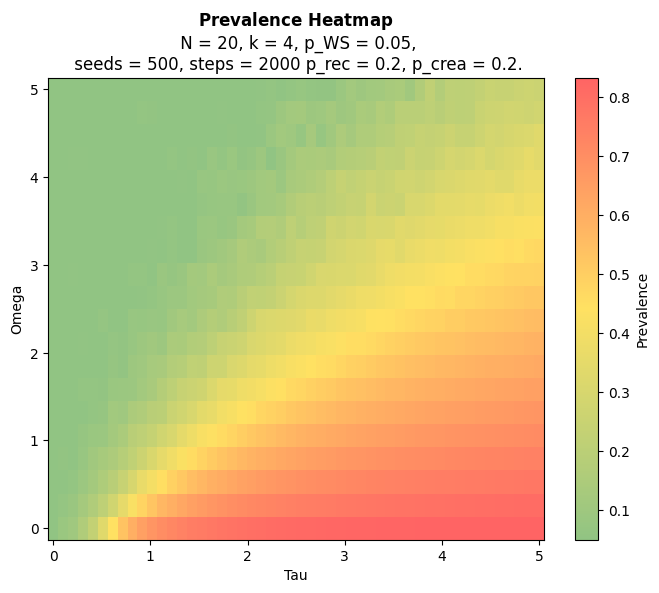

In [ ]:
def plot_prevalence_heatmap(omega_values, taus, prevalence_per_omega,save=False):
    """
    Plots a heatmap of prevalence values with omega on the y-axis, tau on the x-axis,
    and colors representing prevalence values (0=blue, 0.5=yellow, 1=red).

    Parameters:
    omega_values (list): List of omega values for the y-axis.
    taus (array): Array of tau values for the x-axis.
    prevalence_per_omega (dict): Dictionary with omega as keys and prevalence values as lists for each tau.
    """
    # Convert prevalence_per_omega to a 2D array
    prevalence_data = np.array([prevalence_per_omega[omega] for omega in omega_values])

    # Create a custom colormap (blue for 0, yellow for 0.5, red for 1)
    cmap = LinearSegmentedColormap.from_list(
        'prevalence_cmap',
        [(0, '#91C483'), (0.5, '#FFE162'), (1, '#FF6464')]
    )

    # Plotting the prevalence heatmap
    plt.figure(figsize=(8, 6))

    # Use pcolormesh to plot the data
    plt.pcolormesh(taus, omega_values, prevalence_data, cmap=cmap, shading='auto')

    # Add color bar to the right
    cbar = plt.colorbar()
    cbar.set_label('Prevalence')

    # Label axes
    plt.xlabel('Tau')
    plt.ylabel('Omega')

    # Set title
    plt.title(r'$\bf{Prevalence\ Heatmap}$'+f'\n N = {N}, k = {k}, p_WS = {p_ws},\n seeds = {n_seeds}, steps = {steps} p_rec = {p_recov}, p_crea = {p_create}.')

    if save:  plt.savefig(directorio + f'Prevalence Heatmap N = {N} k = {k} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    # Show the plot
    plt.show()



# MAIN PARALELL

This is the Monte Carlo sampling for some taus and omega values.

Set the best parameters you want for tau and omega values, number of seeds, and of steps.

In [ ]:
## Parameters for this cell

max_tau = 5
taus = np.linspace(0, max_tau, 50)  # tau_max = 1/p_recov
average_lifetimes = []
omega_values = np.linspace(0, 5, 20)
n_seeds = 500
steps = 2000

# Storage for results
average_lifetime_per_omega = {omega: [] for omega in omega_values}
prevalence_per_omega = {omega: [] for omega in omega_values}
std_prevalence_per_omega = {omega: [] for omega in omega_values}

# Function to run for each seed
def run_simulation_for_seed(seed, p_inf, p_break, steps, N, k, p_ws, infect_percent):
    # Initialize graph
    #thread = os.getpid()  # Prints the process ID running the task
    seed_G = 0
    G, G_base, status = initialize_graph(N, k, p_ws, infect_percent, seed_G)

    # Epidemic simulation
    infected_in_time = np.zeros(steps)

    # Random array
    np.random.seed(seed)
    dim_ra = steps * N * (k + 1)
    random_array = np.random.rand(dim_ra)
    rand_idx = 0  # global index for random array

    # Evolution of the network
    for step in range(steps):
        G, status,rand_idx = evolution_step(G, G_base, status, random_array,rand_idx)
        infected_in_time[step] = np.sum(status)/N
        if infected_in_time[step] == 0:
            break

    life_time = step_healty(infected_in_time)

    return infected_in_time, life_time #, thread ##import os

# Monte Carlo Simulation
for omega in omega_values:
    p_break = omega * p_create  # Adjust p_break based on omega, p_create constant
    average_lifetime_vs_tau = []
    prevalence_vs_tau = []
    std_prevalence_vs_tau = []

    for tau in taus:
        p_inf = tau * p_recov  # Adjust p_inf based on tau, p_recov is constant
        sum_infected_in_time = np.zeros(steps)  # To sum infected_in_time of each seed
        life_times = np.zeros(n_seeds)  # Array to store life times for each seed

        # Parallelize the Monte Carlo sampling over seeds
        results = Parallel(n_jobs=-1)(delayed(run_simulation_for_seed)(seed, p_inf, p_break, steps, N, k, p_ws, infect_percent) for seed in range(n_seeds))

        # Collect results from parallel execution
        for seed_idx, (infected_in_time, life_time) in enumerate(results):
            sum_infected_in_time += infected_in_time
            life_times[seed_idx] = life_time
            #del infected_in_time
            #print(f"Seed {seed_idx} ran on thread {thread}")

        # Calculate endemic states and average lifetime
        n_endemic_states = endemic_vs_time(life_times, steps, n_seeds, plot=False, save=False, tau=tau, omega=omega)
        average_lifetime = calculate_average_lifetime(n_endemic_states, plot=False)
        average_lifetime_vs_tau.append(average_lifetime)

        # Calculate infected just endemic phase
        mean_infected_in_time = sum_infected_in_time / n_seeds
        infected_just_endemic = np.where(n_endemic_states > 0, mean_infected_in_time / n_endemic_states, 0)

        # Calculate prevalence and standard deviation
        mean_infected, std_dev_infected = find_prevalence(infected_just_endemic, n_endemic_states, n_seeds, plot=False)
        prevalence_vs_tau.append(mean_infected)
        std_prevalence_vs_tau.append(std_dev_infected)

    # Store the results for this omega
    average_lifetime_per_omega[omega] = average_lifetime_vs_tau
    prevalence_per_omega[omega] = prevalence_vs_tau
    std_prevalence_per_omega[omega] = std_prevalence_vs_tau


/tmp/ipykernel_30388/3207395109.py:69: RuntimeWarning: invalid value encountered in true_divide
  infected_just_endemic = np.where(n_endemic_states > 0, mean_infected_in_time / n_endemic_states, 0)
/tmp/ipykernel_30388/3892655039.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  average_lifetime = -1 / slope


## Ploting

In [ ]:
plot_prevalence_heatmap(omega_values, taus, prevalence_per_omega)#,save=True)

In [ ]:
plot_average_lifetime_vs_tau(taus, average_lifetime_per_omega,n_seeds)#,save=True)

In [ ]:
plot_prevalence_vs_tau(taus,prevalence_per_omega,std_prevalence_per_omega, n_seeds)#,save=True)

# Saving on pkl

To save arrays. Still have issues

In [ ]:
import pickle

def save_results(filename, average_lifetime_per_omega, prevalence_per_omega, std_prevalence_per_omega):
    """
    Saves the final arrays to a file using pickle.

    Parameters:
    filename (str): The file path to save the arrays.
    average_lifetime_per_omega (dict): Dictionary containing average lifetime values.
    prevalence_per_omega (dict): Dictionary containing prevalence values.
    std_prevalence_per_omega (dict): Dictionary containing standard deviation of prevalence values.
    """
    with open(filename, 'wb') as f:
        pickle.dump({
            'average_lifetime_per_omega': average_lifetime_per_omega,
            'prevalence_per_omega': prevalence_per_omega,
            'std_prevalence_per_omega': std_prevalence_per_omega
        }, f)
    print(f"Results saved to {filename}")

def load_results(filename):
    """
    Loads the saved arrays from a file using pickle.

    Parameters:
    filename (str): The file path to load the arrays from.

    Returns:
    tuple: A tuple containing (average_lifetime_per_omega, prevalence_per_omega, std_prevalence_per_omega)
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    print(f"Results loaded from {filename}")
    return data['average_lifetime_per_omega'], data['prevalence_per_omega'], data['std_prevalence_per_omega']


In [ ]:
filename = directorio+ f'Results N = {N}, k = {k}, 100p_WS = {int(p_ws*100)}, 10max_tau = {int(max_tau*10)}, seeds = {n_seeds}, steps = {steps}, 100p_rec = {int(p_recov*100)}, 100p_crea = {int(p_create*100)} fecha-{DAY}-{HOUR}:{MINUTE}.pkl'
print(filename)
# After running the simulation and getting the final results
save_results(filename, average_lifetime_per_omega, prevalence_per_omega, std_prevalence_per_omega)


/home/hgutierrez/Documents/Results N = 20, k = 4, 100p_WS = 5, 10max_tau = 50, seeds = 500, steps = 2000, 100p_rec = 20, 100p_crea = 20 fecha-6-11:24.pkl
Results saved to /home/hgutierrez/Documents/Results N = 20, k = 4, 100p_WS = 5, 10max_tau = 50, seeds = 500, steps = 2000, 100p_rec = 20, 100p_crea = 20 fecha-6-11:24.pkl


In [ ]:
####  NAMES
#filename = directorio+ f'Results N = 20, k = 4, 100p_WS = 20, 10max_tau = 50 seeds = 500, steps = 2000 100p_rec = 20, 100p_crea = 20.pkl'

# To load the results from the saved file later
fn_average_lifetime_per_omega, fn_prevalence_per_omega, fn_std_prevalence_per_omega = load_results(filename)
plot_prevalence_heatmap(omega_values, taus, fn_prevalence_per_omega)

FileNotFoundError: [Errno 2] No such file or directory: '/home/hgutierrez/Documents/1Results N = 20, k = 4, 100p_WS = 20 seeds = 500, steps = 2000 100p_rec = 20, 100p_crea = 20'